# Data Manipulation Only Detail Reduction + Unconstrained Models

We will manipulate data, then do density modelling on these modified points.

## Part 1 : Using PCA 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
from auxiliaries.class_struct import GAN 
from sklearn.decomposition import PCA

In [2]:
# params
n_batch = 128
image_size = (28, 28, 1)
n_train = int(60000 / n_batch)
n_test = int(10000 / n_batch)
N_Z = 64
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
X_train = train_images.reshape(60000, 28 * 28)
X_test = test_images.reshape(10000, 28 * 28)

In [3]:
#PCA reduction
pca = PCA(n_components=0.95)
pca = pca.fit(X_train)
X_reduced = pca.transform(X_train)
Xtest_red = pca.transform(X_test)
# reconstruct data from compressed data
pca = PCA(n_components=X_reduced.shape[1])
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
Xtest_rec = pca.inverse_transform(Xtest_red)

non-compressed image


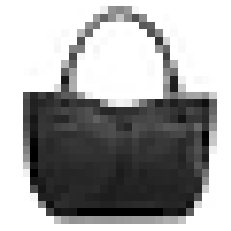

In [4]:
print("non-compressed image")
plt.imshow(X_train[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

95% variance compressed image


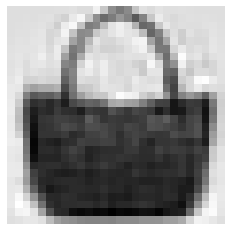

In [5]:
print("95% variance compressed image")
plt.imshow(X_recovered[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

95% variance compressed image


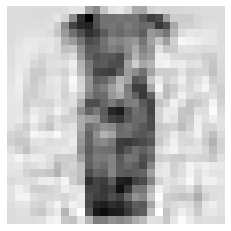

In [6]:
print("95% variance compressed image")
plt.imshow(Xtest_rec[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

95% variance compressed image


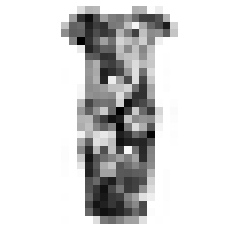

In [7]:
print("95% variance compressed image")
plt.imshow(X_test[100].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

In [8]:
test_images=Xtest_rec
train_images=X_recovered

2022-04-01 17:21:46.022858: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


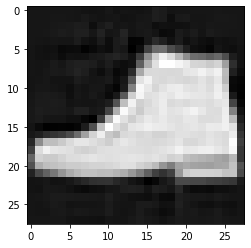

In [9]:
# split dataset
train_images = train_images.reshape(train_images.shape[0], *image_size).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], *image_size).astype("float32") / 255.0

# batching datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(60000)
    .batch(n_batch)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(10000)
    .batch(n_batch)
)
pixels = train_images[42]
plt.imshow(pixels, cmap='gray')
plt.show()


In [10]:
generator = [
    tf.keras.layers.Dense(units=7 *7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="tanh"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=image_size),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [17]:
def build_model(generator,discriminator,N_Z=28):
    # optimizers
    gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
    # model
    model = GAN(
        gen = generator,
        disc = discriminator,
        gen_optimizer = gen_optimizer,
        disc_optimizer = disc_optimizer,
        n_Z = N_Z)

    return model

model=build_model(generator, discriminator)

100%|██████████| 78/78 [00:06<00:00, 11.25it/s]


Epoch: 0 | disc_loss: 1.295653223991394 | gen_loss: 0.6055670976638794


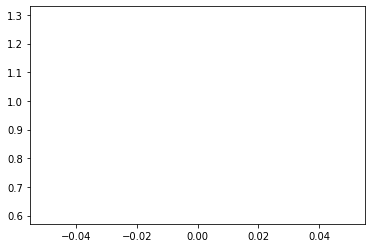

array([1.2956532], dtype=float32)

In [19]:
# saving training stats
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
# training loop
n_epochs = 1
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(n_train), train_dataset), total=n_train

    ): 

        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(n_test), test_dataset), total=n_test
    ):
        loss.append(model.compute_loss(test_x))

    losses.loc[len(losses)] = np.mean(loss, axis=0)

    #prints
    
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plt.plot(losses.disc_loss.values)
    plt.plot(losses.gen_loss.values)
    plt.show()
    

losses.disc_loss.values   

In [ ]:
samples = model.generate(tf.random.normal(shape=(128, 28)))
nex=5
zm=28
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(zm * 5, zm))
for axi in range(1):

    axs.matshow(
                samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
    axs[axi].axis('off')
    plt.show()

    

## Part 2 : Exploiting the Matrix Representation of Images, Part A